In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,  RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
# See all cols and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 90)

In [20]:
# Read in data
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')
sample_sub = pd.read_csv('data/sample_submission.csv')

In [ ]:
train_raw

In [ ]:
test_raw

In [ ]:
sample_sub

In [ ]:
train_raw.isna().sum()

In [ ]:
test_raw.isna().sum()

# Combine train test for Missing value imputation

In [ ]:
# Save sale price for later use
target = train_raw['SalePrice']
# Save for submission
test_ids = test_raw['Id']

# Drop Id and sale price as not needed right now
train1 = train_raw.drop(['Id', 'SalePrice'], axis=1)
test1 = test_raw.drop(['Id'], axis=1)

# Make sure not to shuffle data so concat on top of each other
data1 = pd.concat([train1, test1], axis=0).reset_index(drop=True)

# Drop to make cleaner data
data1 = data1.drop(['GarageYrBlt'], axis=1)

data1

In [57]:
target
target =  pd.DataFrame(target)
print(isinstance(target, pd.DataFrame))

True


# Cleaning

## Set Proper Data Types

In [ ]:
# Check all numeric columns to find features that should be categorical but encoded as numeric
data1.select_dtypes(np.number)

In [29]:
data2 = data1.copy()

In [30]:
# Change to string since this categorical feature is encoded as an integer
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

## Missing Value Imputation

### Categorical Missing Values

In [ ]:
# See if a deature has at least 1 missing value of type object (so it only gets categorical values)
data2.select_dtypes('object').loc[:, data2.isna().sum() > 0].columns

In [32]:
# Go through each feature and figure out when to impute and whether or not missing value is a valid value

# Impute using None for features where NA has meaning
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column] = data2[column].fillna('None')

# Impute using the column mode for features where NA actually means missing value
for column in [
    'MSZoning', 
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])



## Numeric Missing Values

In [ ]:
data3 = data2.copy()
data3.select_dtypes(np.number).isna().sum()

In [ ]:
data3.select_dtypes(np.number).loc[:, data3.isna().sum() > 0].columns

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
columns_to_impute = [
                    'LotFrontage',
                    'MasVnrArea', 
                    'BsmtFinSF1', 
                    'BsmtFinSF2', 
                    'BsmtUnfSF', 
                    'TotalBsmtSF', 
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageCars', 
                    'GarageArea']
data_to_impute = data3[columns_to_impute]

imputed_data = imputer.fit_transform(data_to_impute)
data3[columns_to_impute] = imputed_data

data3.head

In [36]:
# copy of Data4 to be used for pycaret - before onehot & logscaler
pycaret = data3[:train_raw.shape[0]].copy()
print(isinstance(pycaret, pd.DataFrame))
print(pycaret.shape)

True
(1460, 78)


# Feature Transfomations

In [ ]:
from scipy.stats import skew
numeric_cols = data3.select_dtypes(np.number).columns
numeric_cols
# skew(data3['LotFrontage'])

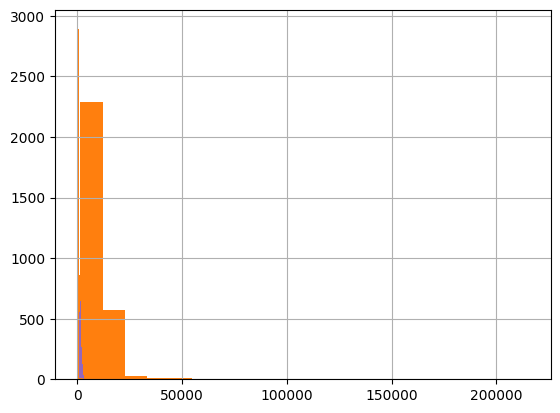

In [38]:
for i in numeric_cols:
    data3[i].hist(bins=20)
    # plt.show()

In [39]:
skews = {}
for i in numeric_cols:
    # skews.append(i, abs(skew(data3[i])))
    skews[i] = abs(skew(data3[i]))


for i in numeric_cols:
    if skews[i] > 0.5:
        data3[i] = np.log1p(data3[i])



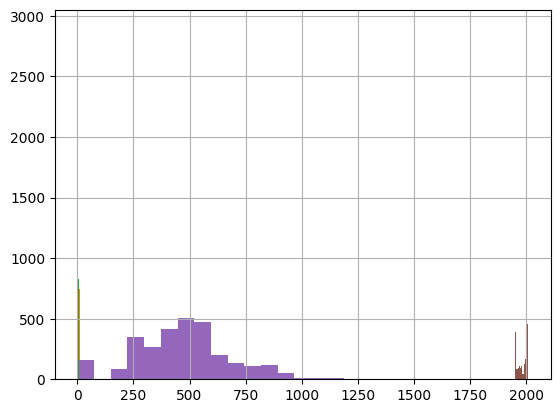

In [40]:
for i in numeric_cols:
    data3[i].hist(bins=20)
    # plt.show()

# Encoding

In [ ]:
data4 = data3.copy()
data4

In [42]:
data4 = pd.get_dummies(data4)
data5 = data4.copy()
data5.shape

(2919, 316)

# Scaling

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data5)

data5 = pd.DataFrame(scaler.transform(data5), index=data4.index, columns=data4.columns)


In [ ]:
## copy of Data5 for pycaret - after onehot & standard/logscaler
pycaret1 = data5[:train_raw.shape[0]].copy()
print(isinstance(pycaret1, pd.DataFrame))
print(pycaret1.shape)
pycaretY = pd.concat([pycaret1, target['SalePrice']], axis=1).reset_index(drop=True)
print(isinstance(pycaret1, pd.DataFrame))
print(pycaretY.shape)
print(pycaretY.head())

## Pycaret Model Selection

In [78]:
from pycaret.utils import version
from pycaret.regression import setup
from pycaret.regression import compare_models
from pycaret.regression import create_model
from pycaret.regression import evaluate_model

print(version())
setup(data=pycaretY, target='SalePrice', session_id=42)
best_model = compare_models(fold=5, n_select=5, sort='RMSE')
print(best_model)


3.0.0


,Description,Value
0,Session id,42
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 317)"
4,Transformed data shape,"(1460, 317)"
5,Transformed train set shape,"(1021, 317)"
6,Transformed test set shape,"(439, 317)"
7,Numeric features,316
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:28:21
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


[LGBMRegressor(random_state=42), RandomForestRegressor(n_jobs=-1, random_state=42), ExtraTreesRegressor(n_jobs=-1, random_state=42), ElasticNet(random_state=42), GradientBoostingRegressor(random_state=42)]


In [87]:
lgbmr = LGBMRegressor(random_state=42)
LBGMR_best = create_model('lgbmr')
# gboost_best = create_model('GradientBoostingRegressor')
# elastic_nest_best = create_model('ElasticNet')
# ex_trees_best = create_model('ExtraTreesRegressor')
# rand_for_best = create_model('RandomForestRegressor')
evaluate_model(LBGMR_best)
# evaluate_model(gboost_best)
# evaluate_model(elastic_nest_best)
# evaluate_model(ex_trees_best)
# evaluate_model(rand_for_best)

ValueError: Estimator lgbmr not available. Please see docstring for list of available estimators.

# Target Transformation

In [ ]:
np.log(target).hist()

In [ ]:
log_target = np.log(target)
log_target

In [ ]:
train_done = data5.loc[:1459, :].copy()
train_done

In [ ]:
test_done = data5.loc[1459:, :].reset_index(drop=True).copy()
test_done

In [ ]:
test_log_target = pd.concat([test_done, log_target], axis=1)
print(test_log_target)
test_log_target

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
knn_reg = KNeighborsRegressor(metric="euclidean",n_neighbors=5)
tree = DecisionTreeRegressor(max_depth=5)


X_train, X_test, y_train, y_test = train_test_split(train_done, log_target, 
                                                    test_size=0.3, 
                                                    random_state=43, 
                                                    shuffle=True)

lr.fit(X_train, y_train)
knn_reg.fit(X_train, y_train)
tree.fit(X_train, y_train)

ylr_pred = lr.predict(X_test)
yknn_pred = knn_reg.predict(X_test)
ytree_pred = tree.predict(X_test)

ylr_pred = lr.predict(X_test)
yknn_pred = knn_reg.predict(X_test)
ytree_pred = tree.predict(X_test)
#ylr_pred = np.exp(ylr_pred)
r2_score(ylr_pred, y_test)
# rsme = np.sqrt(mean_squared_error(target, ylr_pred))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor



X_train, X_test, y_train, y_test = \
    train_test_split(train_done, log_target, test_size=0.25, random_state=12)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=12)

boost = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=8,
    random_state=1)

boost.fit(X_train, y_train)

print("Training Accuracy: %0.2f" % boost.score(X_train, y_train))
print("Validation Accuracy: %0.2f" % boost.score(X_val, y_val))
print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))



In [ ]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier


X_train, X_test, y_train, y_test = \
    train_test_split(train_done, log_target, test_size=0.25, random_state=12)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=12)

print('Train/Valid/Test sizes:', y_train.shape[0], y_val.shape[0], y_test.shape[0])

tree = DecisionTreeRegressor(
                              random_state=1,
                              max_depth=1)


boost = AdaBoostClassifier(estimator=tree,
                           n_estimators=500,
                           algorithm='SAMME',
                           #n_jobs=1,
                           random_state=1)

boost.fit(X_train, y_train)

print("Training Accuracy: %0.2f" % boost.score(X_train, y_train))
print("Validation Accuracy: %0.2f" % boost.score(X_val, y_val))
print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))
